In [1]:
import torch
import torch.nn as nn

from arch.model import RobustGNNModel1

import numpy as np

import matplotlib.pyplot as plt

from utils import GCNN, GAT, GCNH, test_gcnh, pert_S, get_data_dgl

from networkx import from_numpy_array
from dgl import from_networkx

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
assert torch.cuda.is_available()

# Single dataset test

In [3]:
dataset = "CornellDataset"

S, feat, labels, n_class, masks = get_data_dgl(dataset, dev=device)
print("Nodes", S.shape[0])

Nodes 183


In [4]:
n_iters_H = 50
n_epochs = 500
lr = 0.001
wd = 1e-2
eval_freq = 1
es_patience_gcnh = 100
es_patience_rgcnh = 20

lr_S = 1e-3

n_iters = 100
n_iters_S = 1#15

hid_dim = 16
n_layers = 2
bias = True
dropout = 0.25
K = 3
norm_S = True
act = nn.LeakyReLU
batch_norm = False

in_dim = feat.shape[1]
out_dim = n_class

model_params = {
    'in_dim': in_dim,
    'hid_dim': hid_dim,
    'out_dim': out_dim,
    'n_layers': n_layers,
    'act': act,
    'bias': bias,
    'last_act': nn.Softmax(dim=1),
    'dropout': dropout,
    'K': K,
    'norm_S': norm_S,
    'batch_norm': batch_norm
}
model_params_m2 = model_params.copy()
del model_params_m2['K']
del model_params_m2['norm_S']

gamma = 0
beta = 0.1
lambd = 1.

hid_dim_gat = 8
num_heads = 8
gat_params = {
    'feat_drop': 0.6,
    'attn_drop': 0.6
}

In [5]:
eps = 0.05
n_p_noise = 0.01
Sn = pert_S(S, type="rewire_nonsym", eps=eps, n_p_white=n_p_noise)
g = from_networkx(from_numpy_array(Sn)).add_self_loop().to(device)

S = torch.Tensor(S).to(device)
Sn = torch.Tensor(Sn).to(device)

torch.linalg.norm(Sn/torch.linalg.norm(Sn) - S / torch.linalg.norm(S))

tensor(0.3069, device='cuda:0')

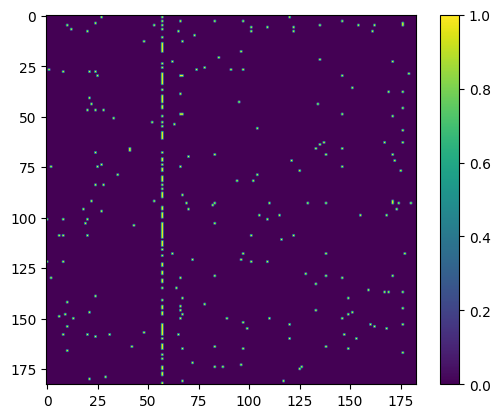

In [6]:
plt.imshow(S.to('cpu').numpy())
plt.colorbar()

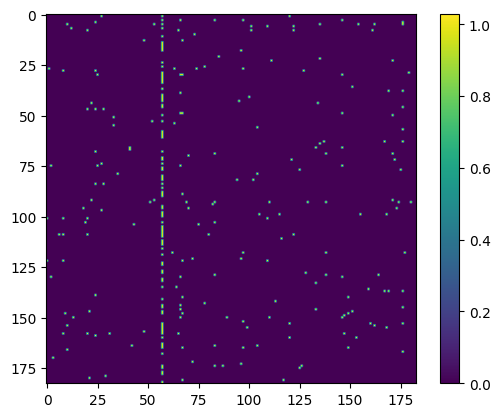

In [7]:
plt.imshow(Sn.to('cpu').numpy())
plt.colorbar()

In [8]:
S_init = Sn.clone()#torch.zeros(Sn.shape, device=device)
model = RobustGNNModel1(S_init, n_iters_H, lr, wd, lr_S, eval_freq, model_params, n_iters, n_iters_S, problem_type="clas", loss_fn=nn.NLLLoss)
model.model = model.model.to(device)

results_dict_m1, S_dict_m1 = model.test_model(Sn, feat, labels, gamma, lambd, beta, train_idx=masks['train'], val_idx=masks['val'], test_idx=masks['test'], norm_S=False, S_true=S, es_patience=es_patience_rgcnh, verbose=True, debug_S=False)

Iteration 1 DONE - Acc Test: 0.6216216216216216 - Err S: 0.6694871187210083
Iteration 2 DONE - Acc Test: 0.6216216216216216 - Err S: 0.6687706708908081
Iteration 3 DONE - Acc Test: 0.6756756756756757 - Err S: 0.6680546402931213
Iteration 4 DONE - Acc Test: 0.7567567567567568 - Err S: 0.6673393845558167
Iteration 5 DONE - Acc Test: 0.7027027027027027 - Err S: 0.6666246652603149
Iteration 6 DONE - Acc Test: 0.7297297297297297 - Err S: 0.6659074425697327
Iteration 7 DONE - Acc Test: 0.7297297297297297 - Err S: 0.6651886701583862
Iteration 8 DONE - Acc Test: 0.7297297297297297 - Err S: 0.6644703149795532
Iteration 9 DONE - Acc Test: 0.7567567567567568 - Err S: 0.6637524366378784
Iteration 10 DONE - Acc Test: 0.7297297297297297 - Err S: 0.6630349159240723
Iteration 11 DONE - Acc Test: 0.7567567567567568 - Err S: 0.6623178124427795
Iteration 12 DONE - Acc Test: 0.7567567567567568 - Err S: 0.6616010069847107
Iteration 13 DONE - Acc Test: 0.7297297297297297 - Err S: 0.6608846783638
Iteration 1

In [9]:
results_dict_m1['best_acc_test'], model.eval_fn(feat, labels, masks['test']), model.eval_fn(feat, labels, masks['train'])

(0.7837837837837838, 0.7297297297297297, 1.0)

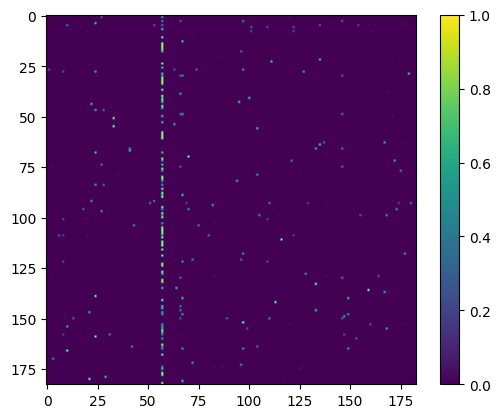

In [10]:
plt.imshow(S_dict_m1['rec_S'].cpu().numpy())
plt.colorbar()

In [11]:
torch.linalg.norm(S_dict_m1['rec_S']), torch.linalg.norm(S)

(tensor(10.5545, device='cuda:0'), tensor(17.2627, device='cuda:0'))

In [12]:
# Even if it is using the class for the Robust GNN, as we are only calling the "stepH" method we are training the GNN with
# the perturbed version of the GSO, so we are ignoring perturbations
n_iters_H_gnn = 50
model = RobustGNNModel1(Sn, n_iters_H_gnn, lr, wd, lr_S, eval_freq, model_params, n_iters, n_iters_S, problem_type="clas", loss_fn=nn.NLLLoss)
model.model = model.model.to(device)

_, _, acc_test, _ = model.stepH(
    feat, labels, masks['train'], masks['val'], masks['test'], verbose=True
)

	Epoch (H) 1/50 - Loss: -0.201 - Train Acc: 0.644 - Test Acc: 0.568
	Epoch (H) 2/50 - Loss: -0.221 - Train Acc: 0.632 - Test Acc: 0.541
	Epoch (H) 3/50 - Loss: -0.238 - Train Acc: 0.632 - Test Acc: 0.568
	Epoch (H) 4/50 - Loss: -0.263 - Train Acc: 0.644 - Test Acc: 0.568
	Epoch (H) 5/50 - Loss: -0.293 - Train Acc: 0.632 - Test Acc: 0.541
	Epoch (H) 6/50 - Loss: -0.309 - Train Acc: 0.655 - Test Acc: 0.541
	Epoch (H) 7/50 - Loss: -0.345 - Train Acc: 0.655 - Test Acc: 0.541
	Epoch (H) 8/50 - Loss: -0.369 - Train Acc: 0.655 - Test Acc: 0.541
	Epoch (H) 9/50 - Loss: -0.403 - Train Acc: 0.655 - Test Acc: 0.541
	Epoch (H) 10/50 - Loss: -0.416 - Train Acc: 0.644 - Test Acc: 0.568
	Epoch (H) 11/50 - Loss: -0.445 - Train Acc: 0.632 - Test Acc: 0.568
	Epoch (H) 12/50 - Loss: -0.453 - Train Acc: 0.655 - Test Acc: 0.541
	Epoch (H) 13/50 - Loss: -0.474 - Train Acc: 0.655 - Test Acc: 0.541
	Epoch (H) 14/50 - Loss: -0.490 - Train Acc: 0.667 - Test Acc: 0.541
	Epoch (H) 15/50 - Loss: -0.528 - Train Acc

In [13]:
model = GCNH(Sn.clone(), **model_params).to(device)

# model training
loss_train, acc_train, acc_test, best_acc_val, best_acc_test = test_gcnh(model, g, feat, labels, masks['train'], masks['val'], masks['test'], n_epochs, lr, wd, es_patience_gcnh, True)
best_acc_test

Epoch 1/500 - Loss Train: 1.614749550819397 - Acc Train: 0.540229856967926 - Acc Val: 0.576271186440678 - Acc Test: 0.45945945382118225
Epoch 4/500 - Loss Train: 1.389973521232605 - Acc Train: 0.6666666865348816 - Acc Val: 0.5932203389830508 - Acc Test: 0.5405405163764954
Epoch 8/500 - Loss Train: 1.1176681518554688 - Acc Train: 0.7471264600753784 - Acc Val: 0.6440677966101694 - Acc Test: 0.5405405163764954
Epoch 12/500 - Loss Train: 0.8535377383232117 - Acc Train: 0.7586206793785095 - Acc Val: 0.6271186440677966 - Acc Test: 0.5945945978164673
Epoch 16/500 - Loss Train: 0.7571218013763428 - Acc Train: 0.7931034564971924 - Acc Val: 0.6271186440677966 - Acc Test: 0.5945945978164673
Epoch 20/500 - Loss Train: 0.5982245802879333 - Acc Train: 0.8275862336158752 - Acc Val: 0.6271186440677966 - Acc Test: 0.5945945978164673
Epoch 24/500 - Loss Train: 0.5164051055908203 - Acc Train: 0.8850574493408203 - Acc Val: 0.6271186440677966 - Acc Test: 0.5945945978164673
Epoch 28/500 - Loss Train: 0.4442

0.6756756756756757

## Pro-GNN

In [14]:
from deeprobust.graph.defense import GCN, ProGNN

No module named 'torch_sparse'


/home/vtenorio/.local/lib/python3.8/site-packages/torch_geometric/typing.py:18: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: libtorch_cuda_cpp.so: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/vtenorio/.local/lib/python3.8/site-packages/deeprobust/graph/defense/__init__.py:15: UserWarning: Please install pytorch geometric if you would like to use the datasets from pytorch geometric. See details in https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html
  warnings.warn("Please install pytorch geometric if you " +


In [15]:
from dataclasses import dataclass

@dataclass
class ProGNNArgs:
    symmetric: bool
    lr: float
    weight_decay: float
    lr_adj: float
    alpha: float
    beta: float
    epochs: int
    only_gcn: bool
    outer_steps: int
    inner_steps: int
    debug: bool
    lambda_: float
    gamma: float
    phi: float

prognn_args = ProGNNArgs(
    symmetric=False,
    lr=0.01,
    weight_decay=5e-4,
    lr_adj=0.01,
    alpha=5e-4,
    beta=1.5,
    epochs=400,
    only_gcn=False,
    outer_steps=1,
    inner_steps=2,
    debug=False,
    lambda_=0,
    gamma=1,
    phi=0
)

In [16]:
# Pro-GNN
model = GCN(nfeat=in_dim,
            nhid=hid_dim,
            nclass=n_class,
            dropout=0.5, device=device)

prognn = ProGNN(model, prognn_args, device)
prognn.fit(feat, Sn, labels, masks['train'], masks['val'])
prognn.test(feat, labels, masks['test'])

/home/vtenorio/.local/lib/python3.8/site-packages/deeprobust/graph/defense/prognn.py:75: UserWarning: If you find the nuclear proximal operator runs too slow, you can modify line 77 to use prox_operators.prox_nuclear_cuda instead of prox_operators.prox_nuclear to perform the proximal on GPU. See details in https://github.com/ChandlerBang/Pro-GNN/issues/1
  warnings.warn("If you find the nuclear proximal operator runs too slow, you can modify line 77 to use prox_operators.prox_nuclear_cuda instead of prox_operators.prox_nuclear to perform the proximal on GPU. See details in https://github.com/ChandlerBang/Pro-GNN/issues/1")


0.4864864864864865

# Exhaustive Tests

In [17]:
EXPS = [
    {
        "dataset": "Cornell",
        "layer": "GCNH",
        "legend": "Cornell-GCNH",
        "fmt": "v-"
    },
    {
        "dataset": "Texas",
        "layer": "GCNH",
        "legend": "Texas-GCNH",
        "fmt": "d-"
    },
    {
        "dataset": "Wisconsin",
        "layer": "GCNH",
        "legend": "Wisconsin-GCNH",
        "fmt": "s-"
    },
    {
        "dataset": "Cornell",
        "layer": "GCNH",
        "legend": "Cornell-GCNH-T",
        "fmt": "v-",
        "transpose": True
    },
    {
        "dataset": "Texas",
        "layer": "GCNH",
        "legend": "Texas-GCNH-T",
        "fmt": "d-",
        "transpose": True
    },
    {
        "dataset": "Wisconsin",
        "layer": "GCNH",
        "legend": "Wisconsin-GCNH-T",
        "fmt": "s-",
        "transpose": True
    },
    {
        "dataset": "Cornell",
        "layer": "RGFGCN",
        "legend": "Cornell-RGCNH",
        "fmt": "v-"
    },
    {
        "dataset": "Texas",
        "layer": "RGFGCN",
        "legend": "Texas-RGCNH",
        "fmt": "d-"
    },
    {
        "dataset": "Wisconsin",
        "layer": "RGFGCN",
        "legend": "Wisconsin-RGCNH",
        "fmt": "s-"
    },
    {
        "dataset": "Cornell",
        "layer": "RGFGCN",
        "legend": "Cornell-RGCNH-T",
        "fmt": "v-",
        "transpose": True
    },
    {
        "dataset": "Texas",
        "layer": "RGFGCN",
        "legend": "Texas-RGCNH-T",
        "fmt": "d-",
        "transpose": True
    },
    {
        "dataset": "Wisconsin",
        "layer": "RGFGCN",
        "legend": "Wisconsin-RGCNH-T",
        "fmt": "s-",
        "transpose": True
    },
    {
        "dataset": "Cornell",
        "layer": "GCNN",
        "legend": "Cornell-GCNN",
        "fmt": "v-"
    },
    {
        "dataset": "Texas",
        "layer": "GCNN",
        "legend": "Texas-GCNN",
        "fmt": "d-"
    },
    {
        "dataset": "Wisconsin",
        "layer": "GCNN",
        "legend": "Wisconsin-GCNN",
        "fmt": "s-"
    },
    {
        "dataset": "Cornell",
        "layer": "ProGNN",
        "legend": "Cornell-ProGNN",
        "fmt": "v-"
    },
    {
        "dataset": "Texas",
        "layer": "ProGNN",
        "legend": "Texas-ProGNN",
        "fmt": "d-"
    },
    {
        "dataset": "Wisconsin",
        "layer": "ProGNN",
        "legend": "Wisconsin-ProGNN",
        "fmt": "s-"
    },
    {
        "dataset": "Cornell",
        "layer": "GAT",
        "legend": "Cornell-GAT",
        "fmt": "v-"
    },
    {
        "dataset": "Texas",
        "layer": "GAT",
        "legend": "Texas-GAT",
        "fmt": "d-"
    },
    {
        "dataset": "Wisconsin",
        "layer": "GAT",
        "legend": "Wisconsin-GAT",
        "fmt": "s-"
    }
]

In [19]:
n_ps = [0., 0.025, 0.05, 0.075, 0.1]

eps = 0.02

n_graphs = 50

accs_test = np.zeros((n_graphs, len(EXPS), len(n_ps)))
errs_S = np.zeros((n_graphs, len(EXPS), len(n_ps)))
for i, n_p in enumerate(n_ps):

    for k, exp in enumerate(EXPS):

        print(f"Starting n_p {n_p} of exp {exp['dataset']} - {exp['layer']}: ", end="")

        for n in range(n_graphs):

            idx = n % 10
            S, feat, labels, n_class, masks = get_data_dgl(exp['dataset'] + "Dataset", dev=device, idx=idx)
                
            print(f"{n+1} ", end="")
            
            Sn = pert_S(S.copy(), type="rewire_nonsym", eps=eps, n_p_white=n_p)
            if n_p == 0. and eps == 0.:
                assert np.all(Sn == S)

            g = from_networkx(from_numpy_array(Sn.copy())).add_self_loop().to(device)

            S = torch.Tensor(S).to(device)
            Sn = torch.Tensor(Sn).to(device)

            if exp['layer'] == "GCNH":
                model = GCNH(Sn.clone(), **model_params).to(device)

                # model training
                loss_train, acc_train, acc_test, best_acc_val, best_acc_test = test_gcnh(model, g, feat, labels, masks['train'], masks['val'], masks['test'], n_epochs, lr, wd, es_patience_gcnh, False)
                err_S = torch.linalg.norm(S - Sn) / torch.linalg.norm(S)
            elif exp['layer'] == "RGFGCN":
                S_init = torch.zeros(S.shape, device=device)
                model = RobustGNNModel1(S_init, n_iters_H, lr, wd, lr_S, eval_freq, model_params,
                                        n_iters, n_iters_S, problem_type="clas", loss_fn=nn.NLLLoss)
                model.model = model.model.to(device)
                results_dict, S_dict = model.test_model(Sn, feat, labels, gamma, lambd, beta,
                                                            train_idx=masks['train'], val_idx=masks['val'], test_idx=masks['test'],
                                                            norm_S=False, S_true=S, es_patience=es_patience_rgcnh, verbose=False
                                                    )
                best_acc_test = results_dict['best_acc_test']
                best_acc_val = results_dict['best_acc_val']
                err_S = S_dict['best_err_S']

            elif exp['layer'] == "GCNN":
                model = GCNN(in_dim, hid_dim, out_dim).to(device)

                # model training
                loss_train, acc_train, acc_test, best_acc_val, best_acc_test = test_gcnh(model, g, feat, labels, masks['train'], masks['val'], masks['test'], n_epochs, lr, wd, es_patience_gcnh, False)
                err_S = torch.linalg.norm(S - Sn) / torch.linalg.norm(S)
            elif exp['layer'] == "GAT":
                model = GAT(in_dim, hid_dim_gat, out_dim, num_heads, gat_params).to(device)

                # model training
                loss_train, acc_train, acc_test, best_acc_val, best_acc_test = test_gcnh(model, g, feat, labels, masks['train'], masks['val'], masks['test'], n_epochs, lr, wd, es_patience_gcnh, False)
                err_S = torch.linalg.norm(S - Sn) / torch.linalg.norm(S)
            elif exp['layer'] == "ProGNN":
                model = GCN(nfeat=in_dim,
                            nhid=hid_dim,
                            nclass=n_class,
                            dropout=0.5, device=device)

                prognn = ProGNN(model, prognn_args, device)
                prognn.fit(feat, Sn, labels, masks['train'], masks['val'])
                best_acc_test = prognn.test(feat, labels, masks['test'])
                err_S = torch.linalg.norm(S - Sn) / torch.linalg.norm(S)
            accs_test[n, k, i] = best_acc_test
            errs_S[n, k, i] = err_S
        print(f"DONE - Accuracy Test: {np.mean(accs_test, 0)[k, i]:.5f}")

Starting n_p 0.0 of exp Cornell - GCNH: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 DONE - Accuracy Test: 0.67459
Starting n_p 0.0 of exp Texas - GCNH: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 DONE - Accuracy Test: 0.75135
Starting n_p 0.0 of exp Wisconsin - GCNH: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 DONE - Accuracy Test: 0.74431
Starting n_p 0.0 of exp Cornell - GCNH: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 DONE - Accuracy Test: 0.67514
Starting n_p 0.0 of exp Texas - GCNH: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 4

Starting n_p 0.025 of exp Wisconsin - ProGNN: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 DONE - Accuracy Test: 0.56706
Starting n_p 0.025 of exp Cornell - GAT: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 DONE - Accuracy Test: 0.40595
Starting n_p 0.025 of exp Texas - GAT: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 DONE - Accuracy Test: 0.58000
Starting n_p 0.025 of exp Wisconsin - GAT: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 DONE - Accuracy Test: 0.51882
Starting n_p 0.05 of exp Cornell - GCNH: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 3

Starting n_p 0.075 of exp Texas - GCNN: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 DONE - Accuracy Test: 0.53189
Starting n_p 0.075 of exp Wisconsin - GCNN: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 DONE - Accuracy Test: 0.49020
Starting n_p 0.075 of exp Cornell - ProGNN: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 DONE - Accuracy Test: 0.47081
Starting n_p 0.075 of exp Texas - ProGNN: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 DONE - Accuracy Test: 0.57243
Starting n_p 0.075 of exp Wisconsin - ProGNN: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 3

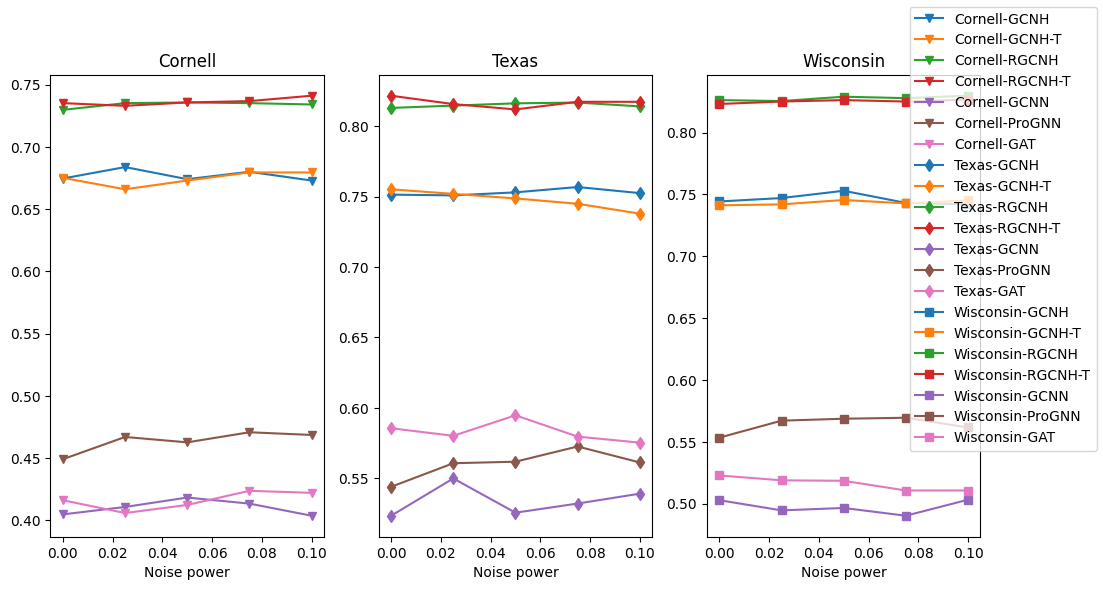

In [23]:
datasets = ["Cornell", "Texas", "Wisconsin"]

f, ax = plt.subplots(1,len(datasets), figsize=(12,6))

for i, exp in enumerate(EXPS):
    idx = datasets.index(exp["dataset"])
    ax[idx].plot(n_ps, accs_test.mean(0)[i,:], exp["fmt"], label=exp["legend"])

for i, d in enumerate(datasets):
    ax[i].set_title(d)
    ax[i].set_xlabel("Noise power")

f.legend()

In [22]:
# To store results as a CSV for later use in PGF Plots
if False:
    with open('results/rgnn-gaussian_n.csv', 'w') as f:
        f.write("P_n;" + ';'.join([exp['legend'] for exp in EXPS]) + "\n")
        for i in range(len(n_ps)):
            f.write(str(n_ps[i]) + ';' + ';'.join([str(accs_test.mean(0)[j,i]) for j in range(len(EXPS))]) + '\n')